In [1]:
%run flow_tools.py

In [2]:
from matplotlib.path import Path
from matplotlib import patches

In [3]:
folders = ['../data/20220207_LCBCAR_Linkers/TCELLTEMPLATE/Spike/',
           '../data/20220207_LCBCAR_Linkers/TCELLTEMPLATE/CD19/',
           '../data/20220207_LCBCAR_Linkers/TCELLTEMPLATE/Stains/']

In [4]:
df = [load_data(folder, colnames = ['WellName', 'Target', 'Effector', 'Ratio','Stain', 'Replicate', 'Plate']) for folder in folders]
df = pd.concat(df)

In [5]:
#remove all rows with values less than 0
df2= df.loc[(df.select_dtypes(include=['number']) > 0).all(axis='columns'), :]

#remove all rows with missing values
df2= df2.dropna()

In [6]:
#define gate for FSC-A vs SSC-A
fsc_ssc_verts = [(4e4, 1e4),
              (1e5, 2.5e4),
              (2.5e5, 1e5),
              (2.5e5, 2.5e5),
              (1e5, 2.5e5),
              (4e4, 5e4),
              (4e4, 5e4),
              (4e4, 1e4)]
fsc_ssc_gate = Path(fsc_ssc_verts)

ssc_verts = [(0, 1e4),
              (2e5, 1.8e5),
              (2.6e5, 1.8e5),
              (2.5e5, 1.3e5),
              (1.25e5, 7.5e4),
              (1e4, 0),
              (0, 1e4)]
ssc_gate = Path(ssc_verts)

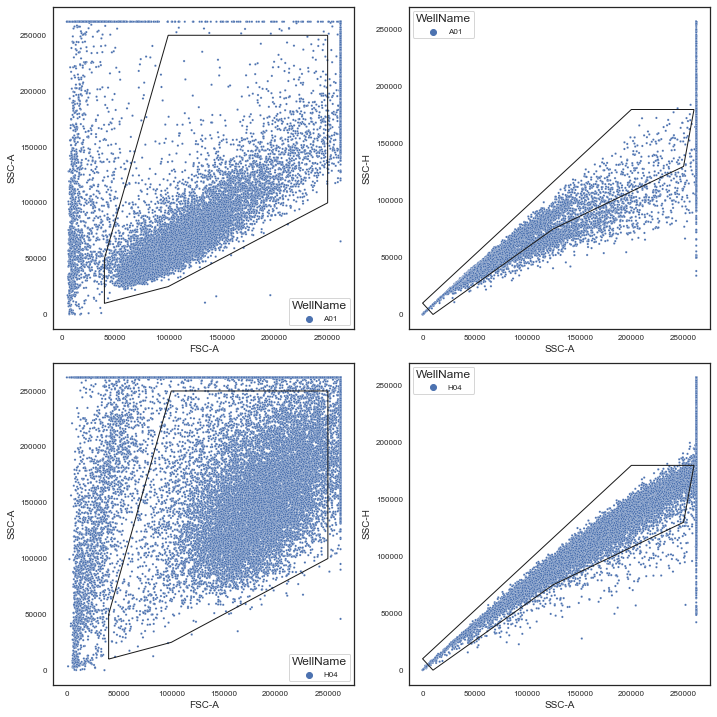

In [9]:
fig, axs = plt.subplots(2,2, figsize=[10,10])
sns.scatterplot(data=df2[(df2['WellName'].isin(['A01'])) & (df2['Plate']=='3')], x='FSC-A', y='SSC-A', marker='o', s=5, edgecolors=None, ax=axs[0,0], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['A01']) & (df2['Plate']=='3')], x='SSC-A', y='SSC-H', marker='o', s=5, edgecolors=None, ax=axs[0,1], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['H04']) & (df2['Plate']=='1')], x='FSC-A', y='SSC-A', marker='o', s=5, edgecolors=None, ax=axs[1,0], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['H04']) & (df2['Plate']=='1')], x='SSC-A', y='SSC-H', marker='o', s=5, edgecolors=None, ax=axs[1,1], hue='WellName')
patch = patches.PathPatch(fsc_ssc_gate, facecolor="None", edgecolor='k')
axs[0,0].add_patch(patch)
patch = patches.PathPatch(fsc_ssc_gate, facecolor="None", edgecolor='k')
axs[1,0].add_patch(patch)
patch = patches.PathPatch(ssc_gate, facecolor="None", edgecolor='k')
axs[0,1].add_patch(patch)
patch = patches.PathPatch(ssc_gate, facecolor="None", edgecolor='k')
axs[1,1].add_patch(patch)
plt.tight_layout()

In [7]:
#filter to gate
df2 = df2[fsc_ssc_gate.contains_points(df2[['FSC-A','SSC-A']].to_numpy())]
df2 = df2[ssc_gate.contains_points(df2[['SSC-A', 'SSC-H']].to_numpy())]
# # gate on singlets
# df2 = gate_density(df2, 0.1, x_var='SSC-A',y_var='SSC-H')

for col in df2.columns:
        if df2[col].dtype=="float32":
            df2["log"+ col]=df2[col].apply(math.log10)

In [11]:
event_counts = df2.groupby(['Plate', 'WellName'])['FSC-A'].count().reset_index()
event_counts['Row'] = event_counts['WellName'].apply(lambda x: x[0])
event_counts['Col'] = event_counts['WellName'].apply(lambda x: x[1:])
event_counts['PlateRow'] = event_counts['Plate'] + ' ' + event_counts['Row']

<AxesSubplot:xlabel='Col', ylabel='PlateRow'>

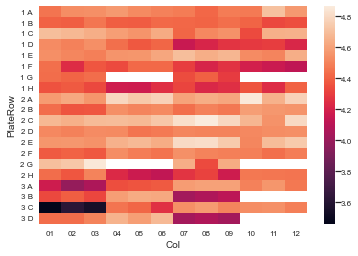

In [13]:
for_heatmap = event_counts.pivot_table(values='FSC-A', index='PlateRow', columns='Col')
sns.heatmap(np.log10(for_heatmap))

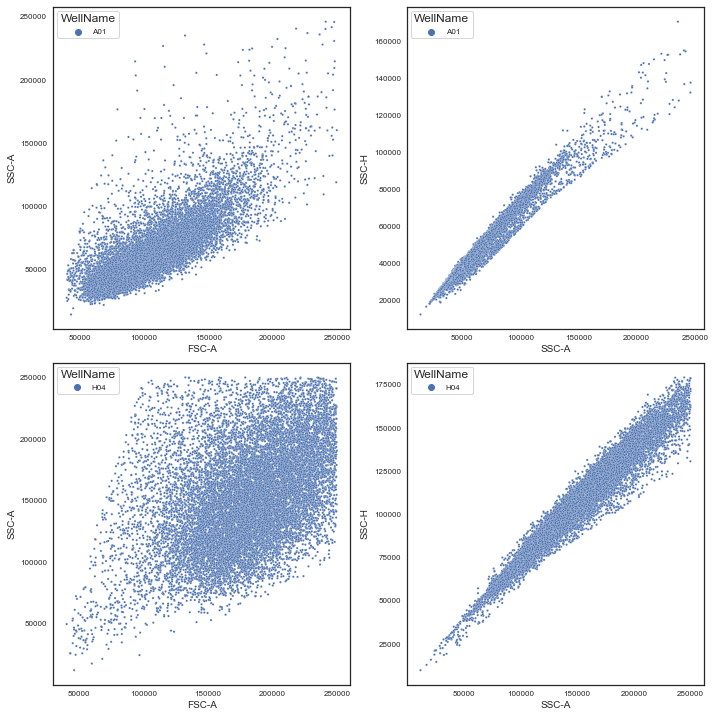

In [14]:
fig, axs = plt.subplots(2,2, figsize=[10,10])
sns.scatterplot(data=df2[(df2['WellName'].isin(['A01'])) & (df2['Plate']=='3')], x='FSC-A', y='SSC-A', marker='o', s=5, edgecolors=None, ax=axs[0,0], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['A01']) & (df2['Plate']=='3')], x='SSC-A', y='SSC-H', marker='o', s=5, edgecolors=None, ax=axs[0,1], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['H04']) & (df2['Plate']=='1')], x='FSC-A', y='SSC-A', marker='o', s=5, edgecolors=None, ax=axs[1,0], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['H04']) & (df2['Plate']=='1')], x='SSC-A', y='SSC-H', marker='o', s=5, edgecolors=None, ax=axs[1,1], hue='WellName')
plt.tight_layout()

Text(0.5, 17.640000000000242, 'log <channel>')

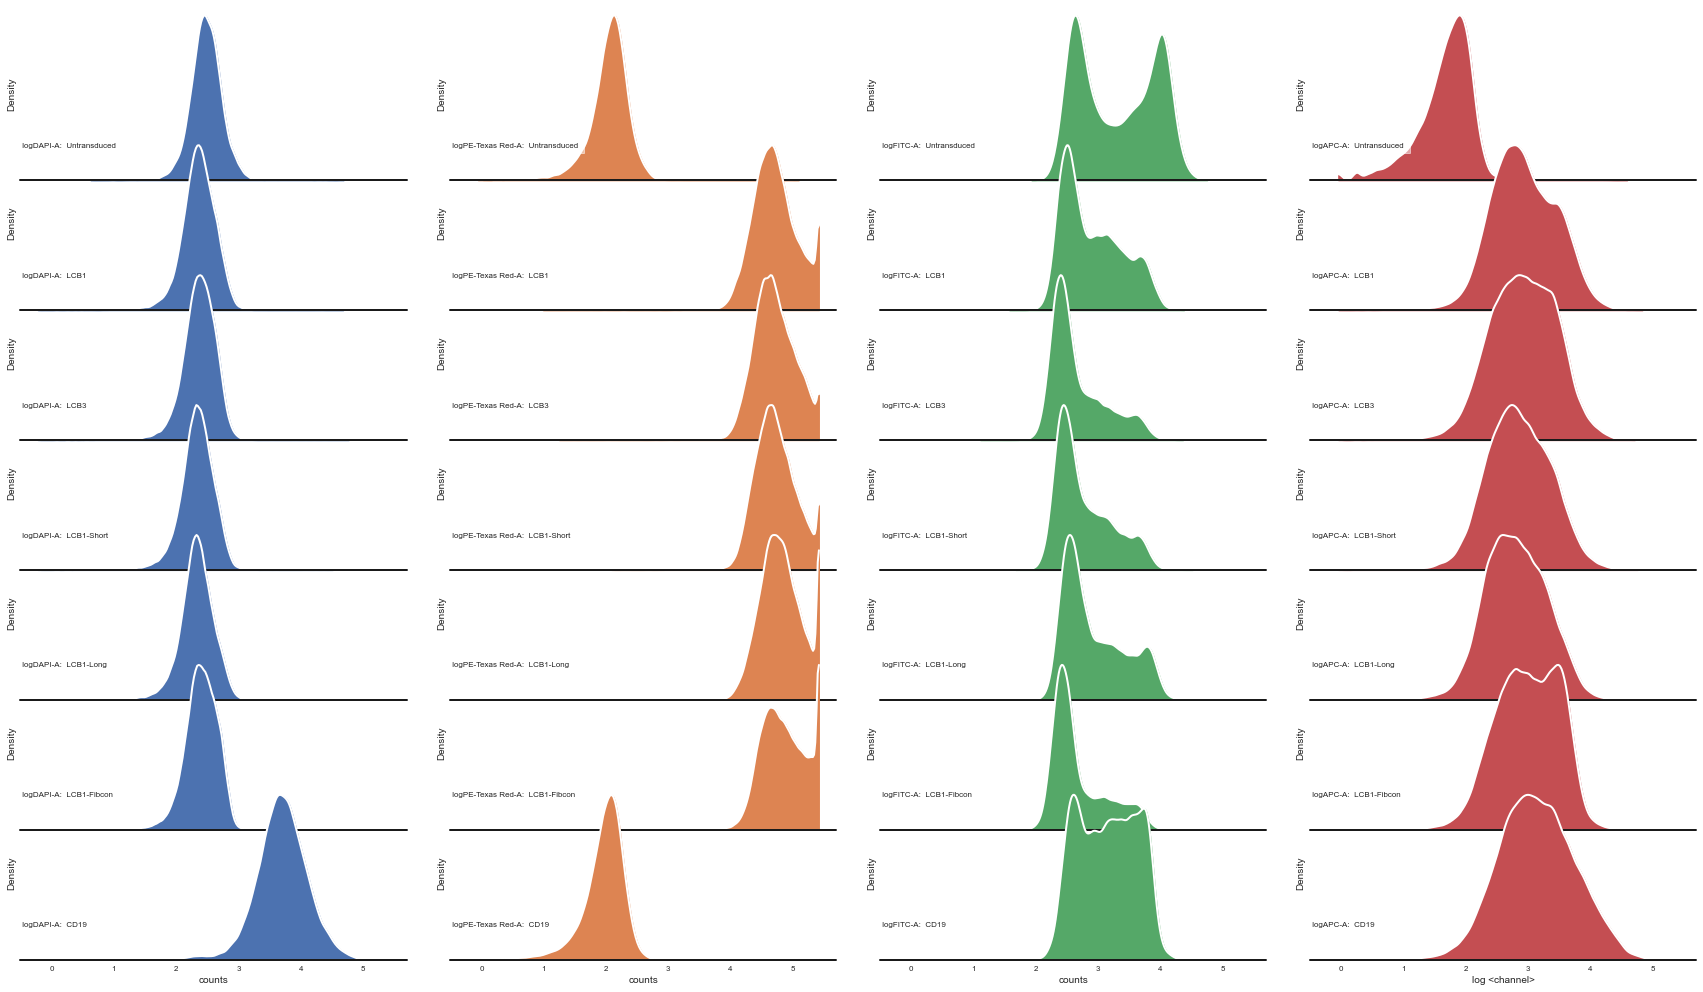

In [16]:
# To figure out what our cutoffs should be, let's look at the untransfected cells for all 4 channels:
# This plots each channel as a column of graphs, and each cell line per row
simplified_df = (df2.reset_index()
                 .melt(value_vars=['logDAPI-A','logPE-Texas Red-A','logFITC-A', 'logAPC-A'], 
                       id_vars=['index','WellName','Effector', 'Ratio', 'Stain'],
                       var_name='channel',
                       value_name='counts'))
g = sns.FacetGrid(data=simplified_df[(simplified_df["Ratio"].isin(['Effector Only'])) &
                                     ~(simplified_df['Effector'].isin(['None'])) &
                                     (simplified_df['Stain']=='Myc')], 
                  row = 'Effector', col='channel', hue='channel', sharey=False, aspect=3, height=2)
g.map(sns.kdeplot, "counts", shade=True, alpha=1, bw_adjust=0.9, clip_on=False, cut=0)
g.map(sns.kdeplot, "counts", color="w", lw=2, bw_adjust=.9, clip_on=False, cut=0)
g.map(plt.axhline, y=0, lw=2, color='k', clip_on=False)

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

for ax in g.axes.flat:
    wellname = ax.get_title().split("=")[2]
    ch = ax.get_title().split('|')[0].split('=')[1]
    ax.text(0,0.2, "{}: {}".format(wellname, ch), ha="left", va="center", 
            bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
    ax.set(facecolor=(0, 0, 0, 0))

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.xlabel("log <channel>")

Text(0.5, 17.640000000000015, 'log <channel>')

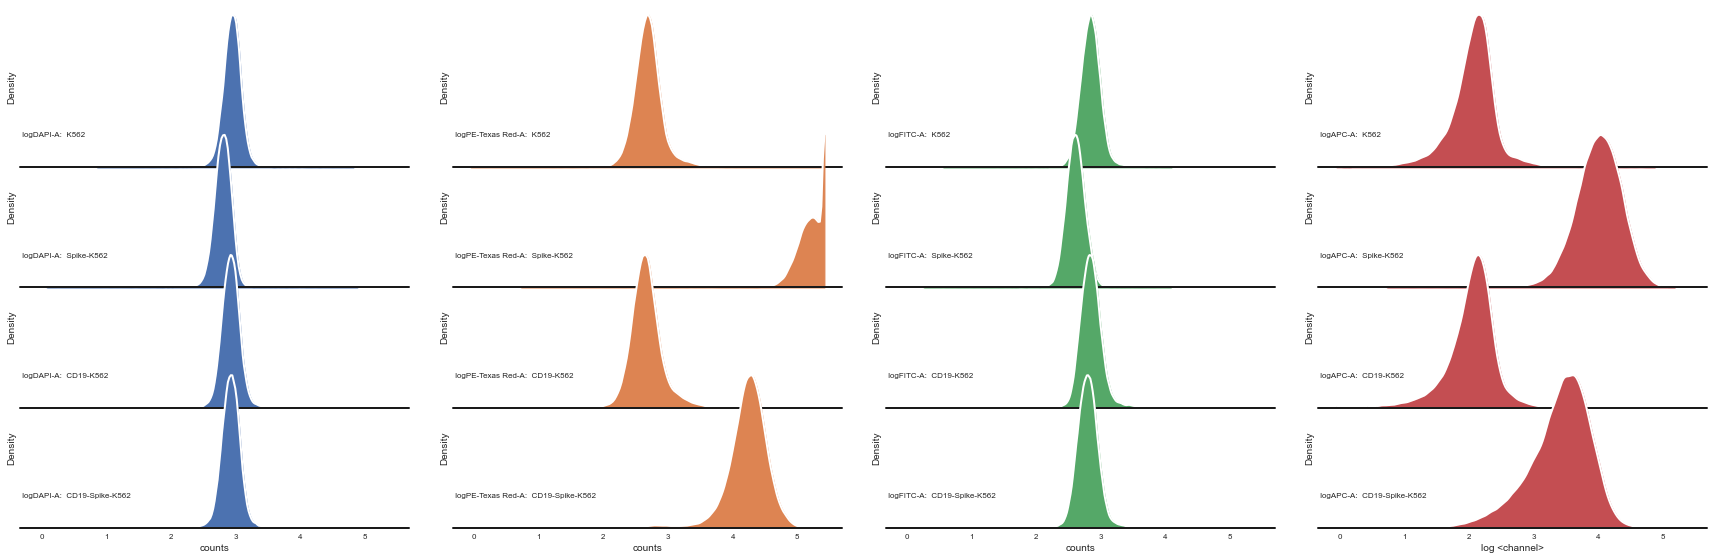

In [17]:
# To figure out what our cutoffs should be, let's look at the untransfected cells for all 4 channels:
# This plots each channel as a column of graphs, and each cell line per row
simplified_df = (df2.reset_index()
                 .melt(value_vars=['logDAPI-A','logPE-Texas Red-A','logFITC-A', 'logAPC-A'], 
                       id_vars=['index','WellName','Target', 'Ratio'],
                       var_name='channel',
                       value_name='counts'))
g = sns.FacetGrid(data=simplified_df[(simplified_df["Ratio"].isin(['Target Only'])) &
                                     ~(simplified_df['Target'].isin(['None']))], 
                  row = 'Target', col='channel', hue='channel', sharey=False, aspect=3, height=2)
g.map(sns.kdeplot, "counts", shade=True, alpha=1, bw_adjust=0.9, clip_on=False, cut=0)
g.map(sns.kdeplot, "counts", color="w", lw=2, bw_adjust=.9, clip_on=False, cut=0)
g.map(plt.axhline, y=0, lw=2, color='k', clip_on=False)

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

for ax in g.axes.flat:
    wellname = ax.get_title().split("=")[2]
    ch = ax.get_title().split('|')[0].split('=')[1]
    ax.text(0,0.2, "{}: {}".format(wellname, ch), ha="left", va="center", 
            bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
    ax.set(facecolor=(0, 0, 0, 0))

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.xlabel("log <channel>")

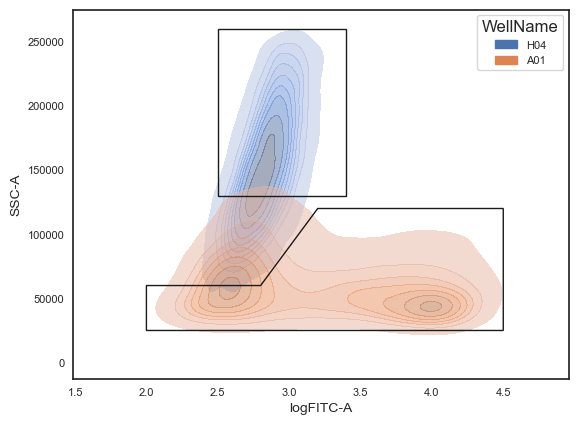

In [8]:
#define gate for FSC-A vs SSC-A
k562_verts = [(2.5, 1.3e5),
              (3.4, 1.3e5),
              (3.4, 2.6e5),
              (2.5, 2.6e5),
              (2.5, 2.5e5),
              (2.5, 1.3e5)]
k562_gate = Path(k562_verts)

tcell_verts = [(2, 2.5e4),
              (4.5, 2.5e4),
              (4.5, 1.2e5),
              (3.2, 1.2e5),
               (2.8, 6e4),
              (2, 6e4),
              (2, 2.5e4)]
tcell_gate = Path(tcell_verts)

parental_wells = df2[((df2['WellName'].isin(['A01'])) & (df2['Plate']=='3')) |
                     (df2['WellName'].isin(['H04']) & (df2['Plate']=='1'))]
fig, axs = plt.subplots(1,1)
sns.kdeplot(data=parental_wells, y='SSC-A', x='logFITC-A', fill=True, hue='WellName', alpha=0.5, ax=axs)
patch = patches.PathPatch(k562_gate, facecolor="None", edgecolor='k')
axs.add_patch(patch)
patch = patches.PathPatch(tcell_gate, facecolor="None", edgecolor='k')
axs.add_patch(patch)

In [9]:
target_filter = k562_gate.contains_points(df2[['logFITC-A','SSC-A']].to_numpy())
effector_filter = tcell_gate.contains_points(df2[['logFITC-A','SSC-A']].to_numpy())

df2['Type'] = 'Unknown'
df2.loc[target_filter, 'Type'] = 'Target'
df2.loc[effector_filter, 'Type'] = 'Effector'

In [10]:
effectors = ['LCB1-CAR', 'Untransduced']
targets = ['K562', 'Spike-K562']
colors = {'Untransduced + K562' : '#8C9696',
          'Untransduced + Spike-K562' : '#6F7978',
          'LCB1-CAR + K562' : '#4272B8',
          'LCB1-CAR + Spike-K562' : '#2158A4'}
linestyles = {'K562' : ':', 'Spike-K562': '-'}
markers = {'K562' : 'o', 'Spike-K562': '^'}

In [11]:
effector_order = ['Untransduced','LCB1', 'LCB3', 'LCB1-Short','LCB1-Long','LCB1-Fibcon','CD19']
target_order = ['None', 'K562', 'CD19-K562', 'Spike-K562', 'CD19-Spike-K562']

In [12]:
expression_df = (df2[(df2['Target']=='None') &
                     (df2['Stain']=='Myc')]
                 .groupby(['Effector','Replicate'])['logAPC-A']
                 .mean()
                 .reset_index())

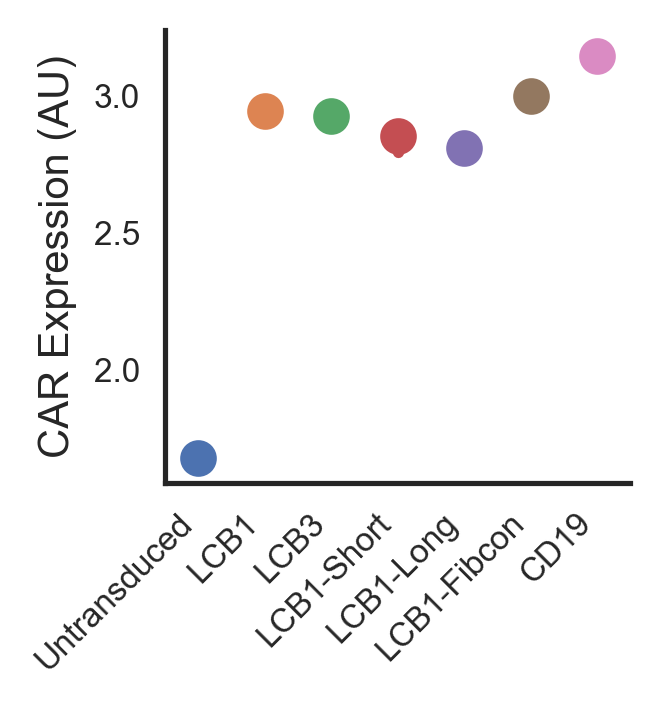

In [13]:
fig, ax = plt.subplots(1,1,figsize=(2,2), dpi=300)
g = sns.pointplot(data=expression_df, x='Effector', y='logAPC-A', hue='Effector', 
                  kind='point', join=False, 
                  order=effector_order,
                  hue_order=effector_order)
g.legend().remove()
g.set_ylabel('CAR Expression (AU)')
g.set_xlabel('')
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.savefig(outputdir+'lcbcar-expression-variant.eps', bbox_inches='tight')

In [14]:
activation_df = (df2[~(df2['Effector']=='None') &
                     (df2['Stain']=='CD25') &
                     (df2['logFITC-A'] > 3.25)]
                 .groupby(['Effector','Target','Ratio','Replicate','Plate'])['logAPC-A']
                 .mean()
                 .reset_index())

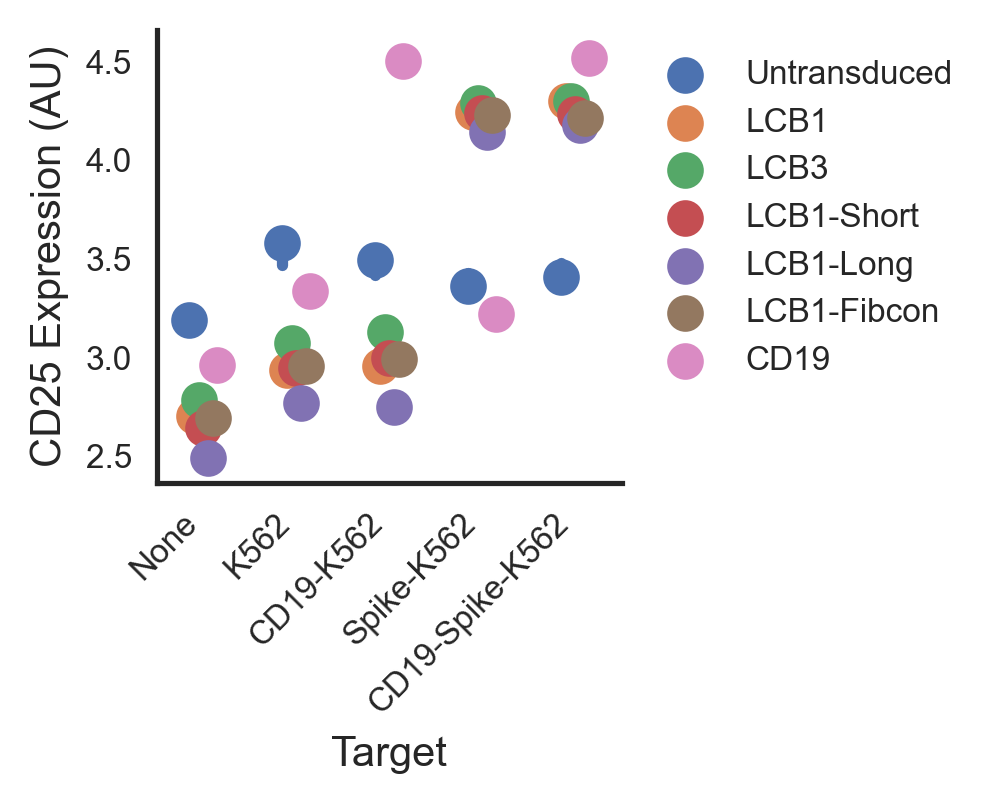

In [15]:
fig, ax = plt.subplots(1,1,figsize=(2,2), dpi=300)
g = sns.pointplot(data=activation_df[activation_df['Ratio'].isin(['1:1','Effector Only'])], x='Target', y='logAPC-A', hue='Effector', 
                kind='point', join=False, estimator=np.median, dodge=0.3, hue_order=effector_order,
                 order=target_order)
g.legend(loc='upper left', bbox_to_anchor=[1,1], frameon=False)
g.set_ylabel('CD25 Expression (AU)')
g.set_xlabel('Target')
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.savefig(outputdir + 'activation_variant.eps', bbox_inches="tight")

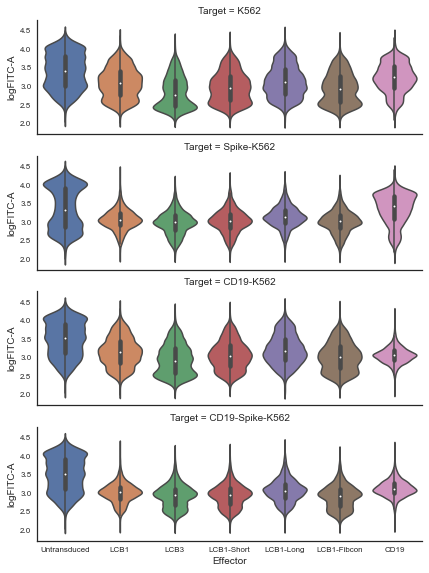

In [32]:
g = sns.catplot(data=df2[(df2['Ratio'].isin(['1:1','None'])) &
                      (df2['Type']=='Effector')], 
                row='Target', hue='Effector', x='Effector', y='logFITC-A', 
                aspect=3, height=2, kind='violin', estimator=np.median, dodge=False)

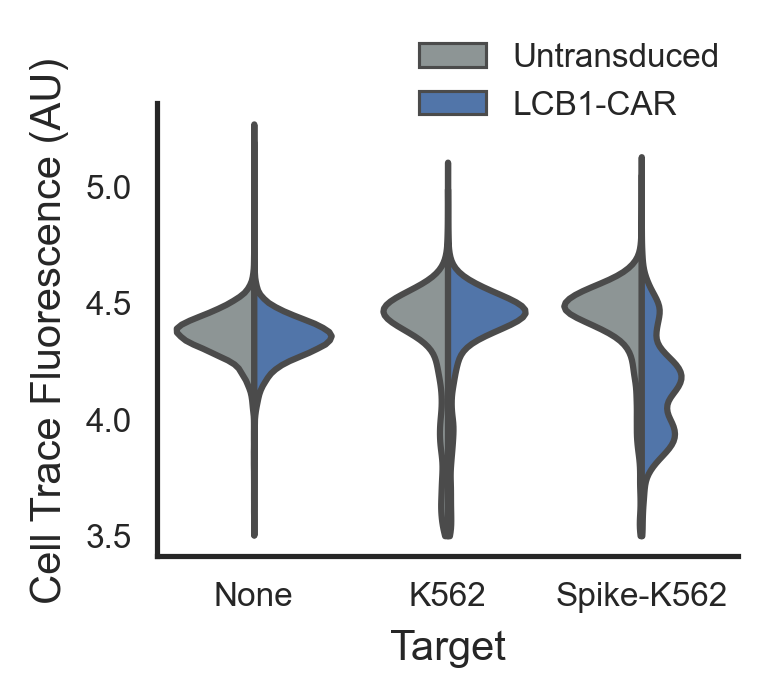

In [19]:
with sns.color_palette(["#8C9696", "#4272B8"]):
    fig, ax = plt.subplots(1,1,figsize=(2.5,2), dpi=300)
    g = sns.violinplot(data=df2[(df2['Ratio'].isin(['1:1','None'])) &
                            (df2['logFITC-A']>3.5) &
                            (df2['Effector'].isin(['LCB1-CAR','Untransduced']))],
                   x='Target',
                   y='logFITC-A',
                   hue='Effector',
                   hue_order=['Untransduced', 'LCB1-CAR'],
                   order=['None', 'K562', 'Spike-K562'],
                   split=True, legend=False, inner=None, cut=0)
    g.legend(loc='upper left', bbox_to_anchor=[0.4,1.2], frameon=False)
    sns.despine()
    plt.ylabel('Cell Trace Fluorescence (AU)')
    
# plt.savefig(outputdir + 'proliferation.svg', bbox_inches="tight")

In [12]:
count_df = (df2.groupby(['WellName','Effector','Target','Ratio','Replicate','Plate'])['Type']
                 .agg(Effectors=(lambda x: np.sum(x == 'Effector')),
                      Targets=(lambda x: np.sum(x == 'Target')))
                 .reset_index())

In [13]:
count_df['Lysis'] = np.nan
count_df['Fold Change From UnT'] = np.nan
for target in ['CD19-Spike-K562', 'CD19-K562','Spike-K562', 'K562']:
    target_filter = (count_df['Target'] == target)
    baseline = count_df[(count_df['Effector'] == 'Untransduced') &
                        (count_df['Ratio']=='1:1') &
                        target_filter]['Targets'].mean()
    count_df.loc[target_filter, 'Lysis'] = 100*(1-(count_df[target_filter]['Targets']/baseline))
    unt_killing = count_df[(count_df['Effector'] == 'Untransduced') &
                        (count_df['Ratio']=='1:1') &
                        target_filter]['Lysis'].mean()
    for effector in effector_order:
        effector_filter = (target_filter &
                           (count_df['Effector'] == effector) &
                           (count_df['Ratio']=='1:1'))
        count_df.loc[effector_filter, 'Fold Change From UnT'] = count_df[effector_filter]['Lysis']/unt_killing

In [14]:
count_df.loc[count_df['Effector']=='LCB1','Effector']='LCB1-CAR'
count_df.loc[count_df['Effector']=='CD19','Effector']='CD19-CAR'
count_df.loc[count_df['Effector']=='LCB3','Effector']='LCB3-CAR'
count_df.loc[count_df['Target']=='CD19-K562','Target']='CD19+'
count_df.loc[count_df['Target']=='Spike-K562','Target']='Spike+'

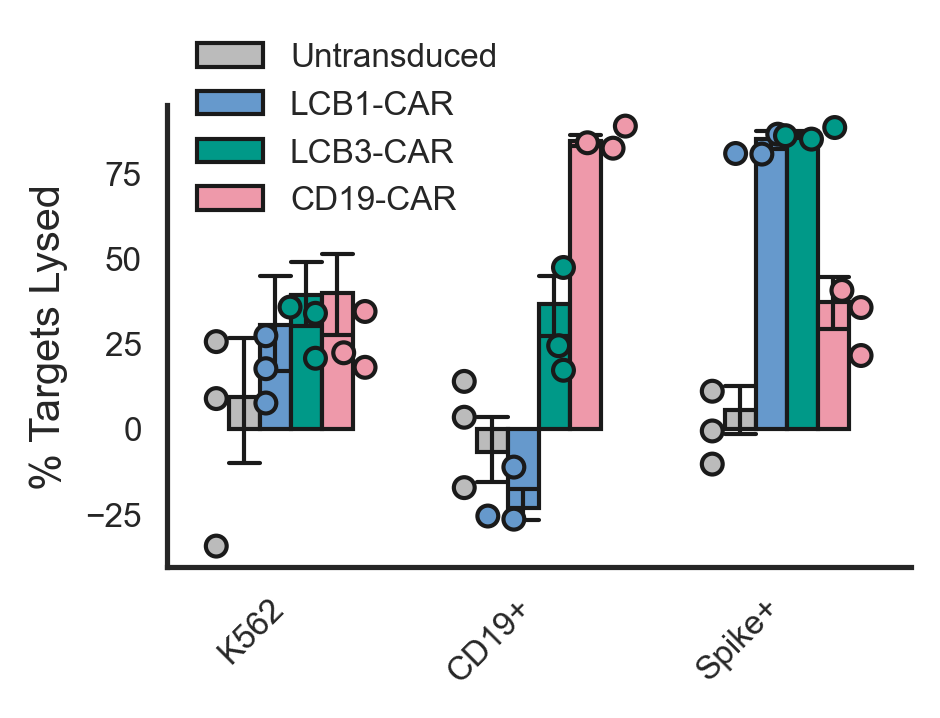

In [15]:
effectors = ['Untransduced','LCB1-CAR','LCB3-CAR','CD19-CAR']
targets = ['K562','CD19+','Spike+']
with sns.color_palette([grey, light_blue, teal, light_red]):
    fig, ax = plt.subplots(1,1,figsize=(3.2,2), dpi=300)
    g = sns.swarmplot(data=count_df[(count_df['Effector'].isin(effectors)) &
                                    (count_df['Ratio']=='1:1')],
                      x='Target', y='Lysis', hue='Effector',
                  order=targets,
                  hue_order=effectors, 
                  edgecolor='k', linewidth=1, dodge=True)
    sns.barplot(data=count_df[(count_df['Effector'].isin(effectors))],
                      x='Target', y='Lysis', hue='Effector',
                  order=targets,
                  hue_order=effectors,
                estimator='mean', 
            dodge=True, edgecolor='k', capsize=0.5, width=0.5, saturation=1,
            err_kws={'linewidth': 1, 'color':'k'})
    g.legend().remove()
    handles, labels = ax.get_legend_handles_labels()
    order = [4,5,6,7]
    plt.legend([handles[idx] for idx in order],
               [labels[idx] for idx in order],
               frameon=False, loc='upper left', bbox_to_anchor=[0,1.2])
    g.set_ylabel('% Targets Lysed')
    g.set_xlabel('')
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.savefig(outputdir+'cd19-donorb-comparison.pdf', bbox_inches='tight')

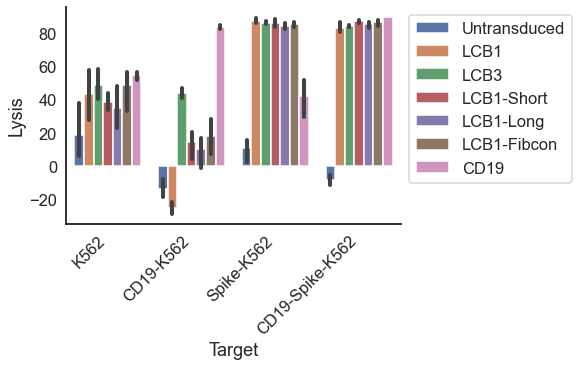

In [39]:
with sns.plotting_context('talk'):
    g = sns.barplot(data=count_df[count_df['Ratio']=='2:1'], 
                  x='Target', y='Lysis', hue='Effector',
                  order=['K562', 'CD19-K562', 'Spike-K562','CD19-Spike-K562'],
                  hue_order=effector_order)
    g.legend().remove()
    plt.legend(bbox_to_anchor=[1,1])
    plt.xticks(rotation=45, ha='right')
    sns.despine()